In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [2]:
def create_random_cities(n):
    """Returns an array of random cities (points) of given size."""
    cities = []
    for i in range(n):
        cities.append(np.random.rand(2))
    return np.array(cities)

In [3]:
node_count = 5
cities = create_random_cities(node_count)

In [4]:
def plot_cities(cities):
    plt.scatter(cities[:, 0], cities[:, 1], s=200, c='blue', alpha=0.1)
    for i, city in enumerate(cities):
        x = city[0]
        y = city[1]
        plt.annotate(i, (x, y), size=8, color='blue', ha='center', va='center')

In [5]:
def distance_between_points(point_A, point_B):
    return np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2)

def get_distance_matrix(cities):
    number_of_cities = len(cities)
    matrix = np.zeros((number_of_cities, number_of_cities))
    for i in range(number_of_cities):
        for j in range(i, number_of_cities):
            distance = distance_between_points(cities[i], cities[j])
            matrix[i][j] = distance
            matrix[j][i] = distance
    return matrix

In [6]:
def calculate_cost(cost_matrix, solution):
    cost = 0
    # Skipping one pair (first, last), since we don't return to the starting point
    return sum([cost_matrix[a][b] for a, b in zip(solution[:-1], solution[1:])])

In [7]:
def solve_tsp_brute_force(cities, starting_city, verbose=True):
    number_of_cities = len(cities)
    initial_order = range(number_of_cities)
    cost_matrix = get_distance_matrix(cities)
    
    # We create all the possible routes
    all_permutations = [list(x) for x in itertools.permutations(initial_order)]
    best_permutation = all_permutations[0]
    best_cost = calculate_cost(cost_matrix, best_permutation)*1000
    
    # We iterate through all the permutations and calculate their cost
    for permutation in all_permutations:
        if permutation[0] != starting_city:
            continue
        current_cost = calculate_cost(cost_matrix, permutation)
        if current_cost < best_cost:
            best_permutation = permutation
            best_cost = current_cost
    if verbose:
        print("Best route:", best_permutation)
        print("Cost:", best_cost)
    return best_permutation

In [8]:
def key(a, b):
    """key returns a key for QUBO dictionary."""
    return a * node_count + b

In [9]:
A = 8500
B = 1

def qubo(distances):
    """qubo generates and returns QUBO dictionary"""
    q = {}
    for i in range(node_count*node_count):
        for j in range(node_count*node_count):
            q.update({(i, j): 0})

    # Constraint that each row has exactly one 1, constant = N*A
    for v in range(node_count):
        for j in range(node_count):
            q[(key(v, j), key(v, j))] += -1*A
            for k in range(j+1, node_count):
                q[(key(v, j), key(v, k))] += 2*A
                q[(key(v, k), key(v, j))] += 2*A

    # Constraint that each column has exactly one 1
    for j in range(node_count):
        for v in range(node_count):
            q[(key(v, j), key(v, j))] += -1*A
            for w in range(v+1, node_count):
                q[(key(v, j), key(w, j))] += 2*A
                q[(key(w, j), key(v, j))] += 2*A

    # Objective that minimizes distance
    for u in range(node_count):
        for v in range(node_count):
            if u != v:
                for j in range(node_count):
                    q[(key(u, j), key(
                        v, (j+1) % node_count))] += B*distances[u][v]

    return q

In [10]:
brute_force_solution = solve_tsp_brute_force(cities, 0)

Best route: [0, 1, 4, 3, 2]
Cost: 1.6175973894390312


In [11]:
def plot_solution(cities, solution, title):
    print(title)
    plot_cities(cities)
    
    plt.xlim([min(cities[:, 0]) - 1, max(cities[:, 0]) + 1])
    plt.ylim([min(cities[:, 1]) - 1, max(cities[:, 1]) + 1])
    for i in range(len(solution) - 1):
        a = i%len(solution)
        b = (i+1)%len(solution)
        A = solution[a]
        B = solution[b]
        plt.plot([cities[A, 0], cities[B, 0]], [cities[A, 1], cities[B, 1]], c='r')

    cost = calculate_cost(get_distance_matrix(cities), solution)
    title_string = "Cost:" + str(cost)
    title_string += "\n" + str(solution)
    plt.title(title_string)

In [12]:
distance_matrix = get_distance_matrix(cities)
q = qubo(distance_matrix)

In [13]:
from dwave_qbsolv import QBSolv
dwave_qbsolv_resp = QBSolv().sample_qubo(q)

In [14]:
dwave_qbsolv_sample = next(iter(dwave_qbsolv_resp))

In [15]:
dwave_qbsolv_route = [-1]*node_count
for node in dwave_qbsolv_sample:
    if dwave_qbsolv_sample[node]>0:
        j = node%node_count
        v = (node-j)/node_count
        dwave_qbsolv_route[j] = int(v)

Brute Force Route


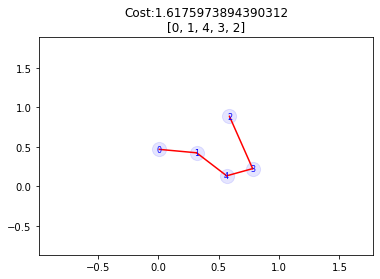

In [16]:
plot_solution(cities, brute_force_solution, "Brute Force Route")

D-Wave QBSolv Route


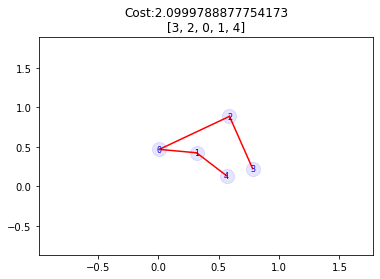

In [17]:
plot_solution(cities, dwave_qbsolv_route, "D-Wave QBSolv Route")